In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from Packages.data import load_csv_to_dataframe, plot_roc_curve, plot_feature_importance # show_tree,
%matplotlib inline

### Load data from Packages.data

In [2]:
file = './Data/data.csv'
df = load_csv_to_dataframe(file)
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_cat',
       'tenure_cat', 'MonthlyCharges_cat', 'TotalCharges_cat'],
      dtype='object')


### Prepare dataframe for train, validation, test split

* 'customerID': drop. A random string assigned to each customer.
* 'tenure'    : drop. A categorical feature was created for this.
* 'MonthlyCharges' : drop. A categorical feature was created for this.
* 'TotalCharges'   : drop. A categorical feature ...
* 'Churn'          : drop. The label is dropped from the X_train, X_test, X_valid datasets

The 'X' dataframe is then one hot encoded via pandas.get_dummies()

In [3]:
X = df.drop(['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_cat'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Churn_cat']

In [4]:
df['Churn'].value_counts()/ len(df)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

### Split data into training, validation and test

The full dataset is split into three parts (training, test, validation).  

Stratified splits due to the unequal partitioning of the dataset (No: 5163 (73%), Yes: 1869 (27%))

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.33,  random_state=42)

In [6]:
print(f"Dataframe: {df.shape}, X.shape: {X.shape}, y.shape: {y.shape}")
print(f"training shape: {X_train.shape}, validiation shape: {X_valid.shape}, testing shape: {X_test.shape}")
print(f"training labels: {y_train.shape}, validation shape: {y_valid.shape}, testing labels: {y_test.shape}")

Dataframe: (7032, 25), X.shape: (7032, 30), y.shape: (7032,)
training shape: (3768, 30), validiation shape: (1857, 30), testing shape: (1407, 30)
training labels: (3768,), validation shape: (1857,), testing labels: (1407,)


### Create DecisionTreeClassifier, fit and predict

The assignment is to compare a Decision Tree classifier with Random Forest

In [7]:
# From the future....
# Best params: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
tree_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)  
tree_clf.fit(X_train, y_train)
y_predict = tree_clf.predict(X_test)

In [8]:
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set:     {tree_clf.score(X_test, y_test):.4f}")

Accuracy on training set: 0.8575
Accuracy on test set:     0.8571


In [9]:
tree_clf.tree_.max_depth

4

### Accuracy of train / test

Accuracy reports how many correct out of total.  This can be misleading if the dataset is very highly skewed.  In this case predictions of only 1 (no churn) will score above 70%!

In [10]:
from sklearn.base import BaseEstimator
class NeverChurnClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_churn_clf = NeverChurnClassifier()
cross_val_score(never_churn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.75      , 0.73407643, 0.71815287])

### Cross-Validation

Cross-Validation predictions based on default DecisionTreeClassifer() (tree_clf)

In [11]:
y_predict_cv = cross_val_predict(tree_clf, X_train, y_train, cv=5)

### Confusion matrix results for predict and cross-val predict

In [12]:
# Confusion Matrix results
print(confusion_matrix(y_test, y_predict))
print(confusion_matrix(y_train, y_predict_cv))

[[968  65]
 [136 238]]
[[2561  205]
 [ 340  662]]


### Classification Report

Classification report for a 'straight' Decision Tree classifier and one for a Cross-Validation (5-fold).

In [13]:
print(classification_report(y_test, y_predict))
print(classification_report(y_train, y_predict_cv))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1033
           1       0.79      0.64      0.70       374

    accuracy                           0.86      1407
   macro avg       0.83      0.79      0.80      1407
weighted avg       0.85      0.86      0.85      1407

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2766
           1       0.76      0.66      0.71      1002

    accuracy                           0.86      3768
   macro avg       0.82      0.79      0.81      3768
weighted avg       0.85      0.86      0.85      3768



In [14]:
# Precision, Recall and F1 Scores
print("Precision, Recall, F1 scores for Churn=yes")
print("="*42)
print(f"Precision: {precision_score(y_test, y_predict):.4f}")
print(f"Recall: {recall_score(y_test, y_predict):.4f}")
print(f"F1: {f1_score(y_test, y_predict):.4f}")
print('*'*8 + "Cross-Validation "+'*'*8)
print(f"Precision (cv): {precision_score(y_train, y_predict_cv):.4f}")
print(f"Recall (cv): {recall_score(y_train, y_predict_cv):.4f}")
print(f"F1 (cv): {f1_score(y_train, y_predict_cv):.4f}")

Precision, Recall, F1 scores for Churn=yes
Precision: 0.7855
Recall: 0.6364
F1: 0.7031
********Cross-Validation ********
Precision (cv): 0.7636
Recall (cv): 0.6607
F1 (cv): 0.7084


### ROC Curve

In [15]:
# Compute y scores for input to metrics
y_probas = cross_val_predict(tree_clf, X_train, y_train, cv=5, method='predict_proba')  # method='decision_function'
y_scores = y_probas[:, 1]

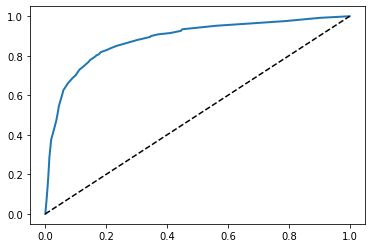

In [16]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)

### ROC AUC

The Area Under Curve (AUC) returns ...

In [17]:
# ROC AUC Curve
print(f"ROC AUC: {roc_auc_score(y_train, y_scores):.4f}")

ROC AUC: 0.8831


### Feature Importance

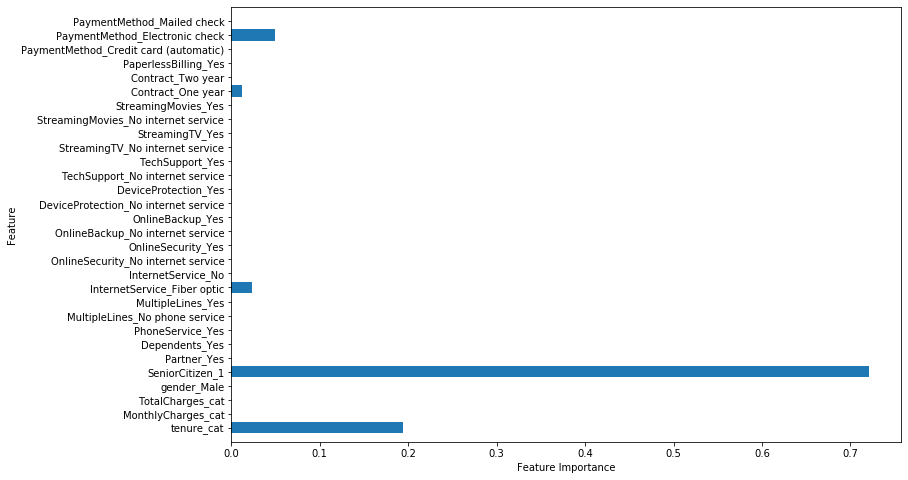

In [18]:
# print(f"Feature importances:\n{tree_clf.feature_importances_}")

plot_feature_importance(X, tree_clf)

## Grid Search CV

Consider exploring the following parameters...

* 'criterion' : ['gini', 'entropy']
* 'max_depth' :
* 'min_samples_split' :
* 'min_samples_leaf' :
* 'max_features' :
* 'max_leaf_nodes' :

In [19]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [2, 5, 10, 20],
          'min_samples_split': [3, 10, 30],
          'max_leaf_nodes': [3, 10, 30],
          'max_features': [3, 10, 30]}
# 
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=5)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 5, 10, 20],
                         'max_features': [3, 10, 30],
                         'max_

### Grid Search CV: best score, best parameters

In [20]:
print(f"Grid search CV, best estimator: {grid_search_cv.best_estimator_}")
print(f"Best score: {grid_search_cv.best_params_}")
print(f"Best params: {grid_search_cv.best_params_}")
print(f"Best index: {grid_search_cv.best_index_}")

Grid search CV, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=30, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Best score: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
Best params: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
Best index: 48


### Grid Search CV: best parameters for Validation

In [21]:
# find best parameters from fit on X_train, y_train
best_params = grid_search_cv.best_params_
# Instantiate Decision Tree Classifier from those best parameters
tree_clf_bp = DecisionTreeClassifier(**best_params)
# Fit Classifier on Validation set
tree_clf_bp.fit(X_valid, y_valid)
# check on test set
bp_score = tree_clf_bp.score(X_test, y_test)

In [22]:
y_predict_bp = tree_clf_bp.predict(X_test)
#y_predict_bp.shape

results = pd.DataFrame(grid_search_cv.cv_results_)
print(results.shape)
results.head()

(108, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002194,3.991610e-04,0.000998,4.422006e-07,2,3,3,3,"{'max_depth': 2, 'max_features': 3, 'max_leaf_...",0.733775,0.733422,0.737052,0.734396,0.734396,0.734607,0.001278,97
1,0.008577,1.267190e-02,0.000998,1.907349e-07,2,3,3,10,"{'max_depth': 2, 'max_features': 3, 'max_leaf_...",0.733775,0.733422,0.737052,0.734396,0.734396,0.734607,0.001278,97
2,0.001995,5.560829e-07,0.000599,4.886945e-04,2,3,3,30,"{'max_depth': 2, 'max_features': 3, 'max_leaf_...",0.733775,0.733422,0.737052,0.734396,0.734396,0.734607,0.001278,97
3,0.001995,2.431402e-07,0.000798,3.988267e-04,2,3,10,3,"{'max_depth': 2, 'max_features': 3, 'max_leaf_...",0.745695,0.751989,0.737052,0.763612,0.742364,0.748142,0.009124,91
4,0.002195,3.990414e-04,0.000399,4.883440e-04,2,3,10,10,"{'max_depth': 2, 'max_features': 3, 'max_leaf_...",0.745695,0.751989,0.737052,0.763612,0.742364,0.748142,0.009124,91


In [23]:
cvrs = grid_search_cv.cv_results_
for mean_score, params in zip(cvrs['mean_test_score'], cvrs['params']):
    print(np.sqrt(mean_score), params)

0.8570923046461517 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 3}
0.8570923046461517 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 10}
0.8570923046461517 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 30}
0.864952166614308 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 3}
0.864952166614308 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 10}
0.864952166614308 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 30}
0.864952166614308 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 3}
0.864952166614308 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 10}
0.864952166614308 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 30}
0.890799874346579 {'max_depth': 2, 'max_features': 10, 'max_leaf_nodes': 3, 'min_samples_split

### Comparison of DT, CV and GSCV prediction scores

In [24]:
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {tree_clf.score(X_test, y_test):.4f}")
print(f"Accuracy from fit on validation set: {bp_score:.4f}")

Accuracy on training set: 0.8575
Accuracy on test set: 0.8571
Accuracy from fit on validation set: 0.8571


### Classification Report Comparison: DT, CV and GSCV

In [25]:
print("=====================  y_test -- y_predict ============")
print("="*55)
print(classification_report(y_test, y_predict))
print("="*55)
print("============  y_train -- y_predict | Cross-Validation ====")
print("="*55)
print(classification_report(y_train, y_predict_cv))
print("="*55)
print("===  y_test -- y_predict_best_parameters | using validation set ==")
print("="*55)
print(classification_report(y_test, y_predict_bp))

=====================  y_test -- y_predict ============
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1033
           1       0.79      0.64      0.70       374

    accuracy                           0.86      1407
   macro avg       0.83      0.79      0.80      1407
weighted avg       0.85      0.86      0.85      1407

============  y_train -- y_predict | Cross-Validation ====
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2766
           1       0.76      0.66      0.71      1002

    accuracy                           0.86      3768
   macro avg       0.82      0.79      0.81      3768
weighted avg       0.85      0.86      0.85      3768

===  y_test -- y_predict_best_parameters | using validation set ==
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1033
           1       0.74      0.71      0.73       374



In [26]:
# scores = np.array(results.mean_test_score).reshape(8, 8)

In [27]:
# sns.heatmap(scores, cmap="YlGnBu", vmin=0.75, vmax=1, annot=True)

In [28]:
# # Precision - Recall Trade-off (for SGDClassifier)

# precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
#
#
# def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
#     plt.plot(thresholds, precisions[:,-1], "b--", label="Precision")
#     plt.plot(thresholds, recalls[:,-1], "g-", label="Recalls")
#
#
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)



# # Confusion Matrix plot
# matrix = confusion_matrix(y_test, y_predict)
# # create pandas dataframe
# class_names = ['Churn_no', 'Churn_yes']
# dataframe_Confusion = pd.DataFrame(matrix, index=class_names, columns=class_names)
# # create heatmap
# sns.heatmap(dataframe_Confusion, annot=True,  cmap="Blues", fmt=".0f")
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.ylabel("True Class")
# plt.xlabel("Predicted Class")
# plt.savefig('./Images/confusion_matrix.png')
# # plt.show()
#
# Plot of Decision Tree
feature_cols = X.columns

# pydotplus.graphviz.InvocationException: GraphViz's executables not found
# works in Linux after sudo apt-get install graphviz
# for Win10, might have to edit Environment variable ???
# show_tree(tree_clf, feature_cols, './Images/tree.png')